In [1]:
from utils import *

In [2]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")


In [167]:
def apply_ds_clean(fn, **fn_kwargs):
    def apply(dataset):
        text = dataset["text"]
        cleaned = fn(text, **fn_kwargs)
        return {"cleaned": cleaned,
                "is_cleaned": cleaned!= text}
    return apply

def count_text_differences(string1, string2):
    """
    Count the number of word-level differences between two strings.
    
    Args:
        string1: Original string
        string2: Modified string
    
    Returns:
        dict: Dictionary with counts of:
            - 'additions': Words added to string2
            - 'deletions': Words deleted from string1
            - 'replacements': Words replaced between strings
            - 'total_changes': Sum of all changes
    """
    import difflib
    
    # Split strings into words
    words1 = string1.split()
    words2 = string2.split()
    
    # Use difflib to get the differences
    diff = difflib.SequenceMatcher(None, words1, words2)
    
    additions = 0
    deletions = 0
    replacements = 0
    
    for tag, i1, i2, j1, j2 in diff.get_opcodes():
        if tag == 'delete':
            deletions += (i2 - i1)
        elif tag == 'insert':
            additions += (j2 - j1)
        elif tag == 'replace':
            # Count as replacements (could also count as deletions + additions)
            replacements += max(i2 - i1, j2 - j1)
    pos = int(len(string1) < 221  and len(string2) < 221)
    return (additions + deletions + replacements)*pos


def show_diff(dataset, n_cases=5, fname=None):
    df = dataset["train"].to_pandas()
    df = df[df["is_cleaned"]]
    df["l"] = df.apply(lambda x: count_text_differences(x["text"], x["cleaned"]), axis=1)
    df = df.sort_values("l", ascending=False)
    diffs = []
    for idx, (t1, t2) in enumerate(zip(df.text.tolist(), df.cleaned.tolist()), 1):
        s1, s2 = highlight_text_diff(t1, t2)
        p = f"{idx}) {s1}\n"
        p = p+ ' '*(len(str({idx}))) + f"{s2}"
        print(p)
        if idx == n_cases:
            break
        diffs.append((t1, t2))
    if fname is not None:
        fpath = f"examples/data_cleaning/{fname}"
        dirname = osp.dirname(fpath)
        os.makedirs(dirname, exist_ok=True)
        with open(fpath, "w") as f:
            for d in diffs:
                f.write("\n".join(d)+"\n")
    return

In [183]:
def clean_html_metadata(text, window_size=5, threshold=0.4):
    """
    Remove HTML tags, metadata attributes, and technical noise from text.
    Handles incomplete HTML fragments and metadata pollution from scraped content.
    Uses context-aware chain removal - removes sequences of words when technical terms
    appear in proximity (within a sliding window), avoiding removal of legitimate words
    that appear in isolation.
    
    Args:
        text: Input text string potentially containing HTML/metadata
        window_size: Size of sliding window for context analysis (default: 5)
        threshold: Minimum proportion of technical terms in window to mark word for removal (default: 0.4)
        
    Returns:
        Cleaned text with HTML and metadata removed
    """
    # First, try to parse with BeautifulSoup to remove complete HTML tags
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text(separator=' ')
    
    # Remove URLs and web-related patterns first (these are always noise)
    text = re.sub(r'https?://[^\s]+', '', text)
    text = re.sub(r'www\.[^\s]+', '', text)
    text = re.sub(r'\bhttp\s+[^\s]*', '', text)
    
    # Remove complete technical metadata blocks (multi-word sequences that are always noise)
    technical_blocks = [
        # HTML/CSS/XML metadata
        r'\bencoding\s+\w+(?:\s+locale\s+\w+)?',
        r'\blocale\s+\w{2}(?:[-_]\w{2})?',
        r'\bisprivate(?:blog)?\s+(?:true|false)',
        r'\bismobile\s+(?:true|false)',
        r'\bmobileclass\s+\w*',
        r'\blanguagedirection\s+(?:ltr|rtl)',
        r'\bfeedlinks\s+\w*',
        r'\blink\s+rel\s+\w+',
        r'\btype\s+application\s+[\w/]+\s+(?:xml)?',
    ]
    
    for pattern in technical_blocks:
        text = re.sub(pattern, ' ', text, flags=re.IGNORECASE)
    
    # Consolidate common technical bigrams into single tokens before splitting
    # This allows us to treat multi-word patterns as single units
    text = re.sub(r'\ba\s+href\b', 'a_href', text, flags=re.IGNORECASE)
    text = re.sub(r'\bn\s+href\b', 'n_href', text, flags=re.IGNORECASE)
    
    # Define technical/metadata words (potential noise when in technical context)
    technical_terms = {
        'html', 'css', 'xml', 'php', 'javascript', 'js',
        'a_href', 'n_href', 'src', 'rel', 'alt', 'link', 'img', 'div', 'span', 'script',
        'width', 'height', 'border', 'margin', 'padding', 'px', 'em', 'data', 'medium', 'src', 'img', 'image',
        'style', 'class', 'type', 'text', 'application', 'background', 'color', 'serif', 'br', 'adjust', 'auto',
        'font', 'size', 'family', 'annotation', 'display', 'indline', 'new', 'roman',
        'http', 'https', 'www', 'url', 'uri',
        'true', 'false', 'null', 'target',
        'stylesheet', 'templates', 'pub', 'message', 'board',
        'vol', 'en', 'del', 'fn',
        'atom', 'ltr', 'rtl', 'utf',
        'titled', 'title', 'smarty', 'jdelivery',
        'twitter', 'provokingbeauty'
    }
    
    # Context-aware chain removal using sliding window
    words = text.split()
    # window_size and threshold are now function parameters
    
    # Mark words that should be removed based on context
    to_remove = [False] * len(words)
    
    for i in range(len(words)):
        # Get window around current word
        start = max(0, i - window_size // 2)
        end = min(len(words), i + window_size // 2 + 1)
        window = words[start:end]
        
        # Count technical terms in window
        tech_count = sum(1 for w in window if w.lower().strip('.,!?;:') in technical_terms)
        
        # If current word is technical AND surrounded by technical terms, mark for removal
        current_word = words[i].lower().strip('.,!?;:')
        if current_word in technical_terms:
            if tech_count >= threshold * len(window):
                to_remove[i] = True
        # Also remove non-technical words if they're surrounded by many technical terms
        elif tech_count >= 0.6 * len(window):  # Higher threshold for non-technical words
            to_remove[i] = True
    
    # Expand removal to include orphaned single words between removed sequences
    for i in range(1, len(to_remove) - 1):
        if not to_remove[i] and to_remove[i-1] and to_remove[i+1]:
            # Single word sandwiched between removed words - likely part of technical sequence
            to_remove[i] = True
    
    # Clean up trailing technical fragments
    # Remove any remaining technical terms at the end of the text
    # BUT: Don't remove if it's just a single word (likely legitimate text)
    # EXCEPT: Always remove consolidated bigrams like a_href, n_href (these are always noise)
    always_remove_terms = {'a_href', 'n_href'}
    
    i = len(to_remove) - 1
    trailing_count = 0
    trailing_words = []
    while i >= 0:
        current_word = words[i].lower().strip('.,!?;:')
        if current_word in technical_terms:
            trailing_count += 1
            trailing_words.append(current_word)
            i -= 1
        else:
            break  # Stop when we hit a non-technical word
    
    # Mark for removal if:
    # 1. There are 2 or more trailing technical words, OR
    # 2. The single trailing word is in always_remove_terms (consolidated bigrams)
    if trailing_count >= 2 or (trailing_count == 1 and trailing_words[0] in always_remove_terms):
        for i in range(len(to_remove) - trailing_count, len(to_remove)):
            to_remove[i] = True
    
    # Reconstruct text without marked words
    cleaned_words = [words[i] for i in range(len(words)) if not to_remove[i]]
    text = ' '.join(cleaned_words)
    
    # Remove any remaining unigrams containing 'href'
    text = re.sub(r'\b\w*href\w*\b', '', text, flags=re.IGNORECASE)
    
    # Clean up: remove multiple spaces and trim
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

In [184]:
dataset_cleaned = dataset.map(apply_ds_clean(clean_html_metadata, window_size=5, threshold=0.35))
show_diff(dataset_cleaned, n_cases=60, fname="html_cleaning.txt")


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

1) i feel so dirty in you i crash cars br style background color white color font family georgia times new roman times serif font size px line height
   i feel so dirty in you i crash cars
2) i feel good having defended the sanctity of the span style webkit text size adjust auto webkit text stroke width px background color white color display inline
   i feel good having defended the sanctity of the
3) i feel studying and doing homework again after weeks of holidays target blank img title stumbleupon class ssba alt stumbleupon src http www
   i feel studying and doing homework again after weeks of holidays
4) i will say that a little piece of me feels agitated when i watch discussions on race and there will i style color font family georgia serif font size px line height
   i will say that a little piece of me feels agitated when i watch discussions on race and there will i
5) i feel a change coming espa a hd target blank rel nofollow title google img src http sky sport
   i feel a cha

In [95]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_missing_apostrophes))
show_diff(dataset_cleaned, n_cases=5,fname="fixed_apos.txt")


1) i feel way when meet again i ll ask you re doing and you ll say fine ask i m doing and i ll lie i ll say ordinary it s ordinary day
   i feel way when meet again i'll ask you're doing and you'll say fine ask i'm doing and i'll lie i'll say ordinary it's ordinary day
2) i feel desperately unhappy if this is me missing richard then i can t handle it it s too much i ve had enough of it i m a mess i know it s not me i still feel like myself
   i feel desperately unhappy if this is me missing richard then i can't handle it it's too much i've had enough of it i'm a mess i know it's not me i still feel like myself
3) i don t believe in my weakness he is strong i don t believe i am more than a conqueror and i feel like i m a real fake and it s not fine
   i don't believe in my weakness he is strong i don't believe i am more than a conqueror and i feel like i'm a real fake and it's not fine
4) i see a woman sitting alone at a table in starbucks or at a restaurant if i m feeling playful and c

In [78]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_slang_text))
show_diff(dataset_cleaned, "slang_norm.txt")


0) i feel romantic feelings in my soul and begging to god make u me ur love me ur feeling me ur soul me i wanna to hear the beat of heart by u for me ever if u wanna so otherwise i am nothing without u
   i feel romantic feelings in my soul and begging to god make you me your love me your feeling me your soul me i wanna to hear the beat of heart by you for me ever if you wanna so otherwise i am nothing without you
1) i always think about my past and i start crying also i can be happy then idk why but i start feeling sad
   i always think about my past and i start crying also i can be happy then i do not know why but i start feeling sad
2) i feel so empty idk i came home early from school
   i feel so empty i do not know i came home early from school
3) i feel like my meds arent working correctly and idk its weird
   i feel like my meds arent working correctly and i do not know its weird
4) i just read this on yahoo and thought it verrrrrrrryyyy interesting n n n n red may be the color 

In [79]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_contructions))
show_diff(dataset_cleaned, "contructions.txt")

0) i was young but i cant get that feeling back shes got a killers grin on and maybe im just too jaded now and i wont leave ill try and pretend cause weve got nothing to lose but time so here we go again
   i was young but i cannot get that feeling back she is got a killers grin on and maybe i am just too jaded now and i will not leave ill try and pretend because we have got nothing to lose but time so here we go again
1) i feel they think im always glad but theres something they dont no im the one whos feeling sad
   i feel they think i am always glad but there is something they do not no i am the one who is feeling sad
2) i dunno the word im even looking for i guess because im not exactly how i feel im selfish i know
   i do not know the word i am even looking for i guess because i am not exactly how i feel i am selfish i know
3) i m tryin my level best be a gud pal but i cant help if u dont understad what i feel abt u dats ur problemn i don think carin for sum is a crime img src rte

In [80]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_repeated_chars))
show_diff(dataset_cleaned, "rep_chars.txt")

0) i want to be recless but im feeling so uptight put your mamma in a headlock baby and do it right whooooos got the crack whooooooooos got the crack whooooo s got the crack whos got the craaaaaaack
   i want to be recless but im feeling so uptight put your mamma in a headlock baby and do it right whoos got the crack whoos got the crack whoo s got the crack whos got the craack
1) i am so festive this feels so delicious wheeeeee what a great night
   i am so festive this feels so delicious whee what a great night
2) i shalt say we did cos i din feel a thing when he wrote hw he is keen on xxx
   i shalt say we did cos i din feel a thing when he wrote hw he is keen on xx
3) i knew it was the holy spirit at work plus it feels divine in the gooooood way like a massage reassuring me
   i knew it was the holy spirit at work plus it feels divine in the good way like a massage reassuring me
4) i was feeling really horny all afternoon with no one to fulfill ma sexual desire and only had my bed a

In [81]:

dataset_cleaned = dataset.map(apply_ds_clean(clean_sample))
show_diff(dataset_cleaned, "total.txt")

0) im feeling lucky width li style border px list style outside margin px px
   i am feeling lucky
1) i feel romantic feelings in my soul and begging to god make u me ur love me ur feeling me ur soul me i wanna to hear the beat of heart by u for me ever if u wanna so otherwise i am nothing without u
   i feel romantic feelings in my soul and begging to god make you me your love me your feeling me your soul me i want to to hear the beat of heart by you for me ever if you want to so otherwise i am nothing without you
2) i will say that a little piece of me feels agitated when i watch discussions on race and there will i style color font family georgia serif font size px line height
   i will say that a little piece of me feels agitated when i watch discussions on race and there will i
3) i m tryin my level best be a gud pal but i cant help if u dont understad what i feel abt u dats ur problemn i don think carin for sum is a crime img src rte emoticons smile sarcastic
   i am tryin my lev

In [100]:
df = dataset["train"].to_pandas()
duplicates = df[df.duplicated(subset=["text"], keep=False)]
ctr = 0
for t, tdf in duplicates.groupby("text"):
    if len(set(tdf.label.tolist()))>1:
        ctr+=1
        print(set(tdf.label.tolist()))
print(ctr)

{1, 2}
{1, 2}
{3, 4}
{1, 2}
{4, 5}
{4, 5}
{1, 2}
{4, 5}
{3, 4}
{1, 2}
{1, 2}
{1, 2}
{3, 4}
{4, 5}
{4, 5}
{1, 2}
{1, 5}
{0, 4}
{3, 4}
{1, 2}
{1, 2}
{1, 2}
{0, 3}
{0, 3}
{0, 3}
{1, 2}
{1, 2}
{1, 2}
{4, 5}
{1, 2}
30


In [105]:
idx2label, label2idx = load_label_mapping()
titles = ["Labels", "Tweet"]
max_tweet_len = 80
max_label_len = 15
print(f"{titles[0]:^{max_label_len}} |{titles[1]:^{max_tweet_len}}")
print("-"*(max_label_len+max_tweet_len+3))
ctr = 0
for t, tdf in duplicates.groupby("text"):
    if True: #len(t) <= max_tweet_len:
        labels = "({})".format('/'.join([idx2label[idx] for idx in tdf.label.tolist()]))
        print(f"{labels:<{max_label_len}} | {t}")
        ctr += 1
        if ctr == 100:
            break

    Labels      |                                     Tweet                                      
--------------------------------------------------------------------------------------------------
(Joy/Love)      | i am not amazing or great at photography but i feel passionate about it
(Love/Joy)      | i began to feel accepted by gaia on her own terms
(Fear/Anger)    | i bet taylor swift basks in the knowledge that the boys she writes songs about probably feel tortured
(Love/Joy)      | i cant escape the tears of sadness and just true grief i feel at the loss of my sweet friend and sister
(Fear/Surprise) | i could feel myself hit this strange foggy wall
(Surprise/Fear) | i feel a remembrance of the strange by justin aryiku falls into the latter category
(Love/Joy)      | i feel im being generous with that statement
(Fear/Surprise) | i feel kind of strange
(Fear/Anger)    | i feel like a tortured artist when i talk to her
(Joy/Love)      | i feel like i am very passionate about youtube

In [162]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import load_label_mapping


def plot_class_distribution(dataset_dict, label_mapping_path='classes.json', fname=None):
    """
    Plot class distribution comparison between train, validation, and test splits.
    
    Args:
        dataset_dict: DatasetDict with 'train', 'validation', and 'test' splits
        label_mapping_path: Path to JSON file containing label mappings (default: 'classes.json')
        fname: Optional file path to save the figure (without extension, will be saved as .jpg)
    """
    # Load label mapping
    idx2label, label2idx = load_label_mapping(label_mapping_path)
    
    # Extract labels for all splits
    train_labels = dataset_dict['train']['label']
    val_labels = dataset_dict['validation']['label']
    test_labels = dataset_dict['test']['label']
    
    # Count label occurrences
    train_counts = pd.Series(train_labels).value_counts().sort_index()
    val_counts = pd.Series(val_labels).value_counts().sort_index()
    test_counts = pd.Series(test_labels).value_counts().sort_index()
    
    # Normalize to get proportions
    train_proportions = train_counts / train_counts.sum()
    val_proportions = val_counts / val_counts.sum()
    test_proportions = test_counts / test_counts.sum()
    
    # Prepare data for plotting with actual label names
    label_indices = train_proportions.index.tolist()
    label_names = [idx2label[idx] for idx in label_indices]
    train_values = train_proportions.values
    val_values = val_proportions.values
    test_values = test_proportions.values
    
    # Create bar plot
    x = np.arange(len(label_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(7, 4))
    bars1 = ax.bar(x - width, train_values, width, label='Train', alpha=0.8)
    bars2 = ax.bar(x, val_values, width, label='Validation', alpha=0.8)
    bars3 = ax.bar(x + width, test_values, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Class Label', fontsize=12)
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(label_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars (show as percentages)
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height*100:.1f}%',
                   ha='center', va='bottom', fontsize=5.5)
    
    plt.tight_layout()
    
    if fname:
        # Ensure the directory exists
        directory = os.path.dirname(fname)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{fname}.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_length_distribution(dataset_dict, fname=None):
    """
    Plot text length distribution (in words) for train, validation, and test splits.
    Displays overlapping normalized histograms for comparison.
    
    Args:
        dataset_dict: DatasetDict with 'train', 'validation', and 'test' splits containing 'text' field
        fname: Optional file path to save the figure (without extension, will be saved as .jpg)
    """
    # Calculate word counts for each split
    train_lengths = [len(text.split()) for text in dataset_dict['train']['text']]
    val_lengths = [len(text.split()) for text in dataset_dict['validation']['text']]
    test_lengths = [len(text.split()) for text in dataset_dict['test']['text']]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Determine common bins for all plots
    all_lengths = train_lengths + val_lengths + test_lengths
    bins = np.linspace(0, max(all_lengths), 50)
    
    # Plot overlapping histograms with normalization (density=True)
    ax.hist(train_lengths, bins=bins, color='skyblue', edgecolor='black', 
            alpha=0.5, label='Train', density=True)
    ax.hist(val_lengths, bins=bins, color='lightgreen', edgecolor='black', 
            alpha=0.5, label='Validation', density=True)
    ax.hist(test_lengths, bins=bins, color='lightcoral', edgecolor='black', 
            alpha=0.5, label='Test', density=True)
    
    ax.set_xlabel('Text Length (words)', fontsize=12)
    ax.set_ylabel('Normalized Frequency (Density)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add statistics box
    stats_text = f'Train: Mean={np.mean(train_lengths):.1f}, Median={np.median(train_lengths):.1f}\n'
    stats_text += f'Val: Mean={np.mean(val_lengths):.1f}, Median={np.median(val_lengths):.1f}\n'
    stats_text += f'Test: Mean={np.mean(test_lengths):.1f}, Median={np.median(test_lengths):.1f}'
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    
    if fname:
        # Ensure the directory exists
        directory = os.path.dirname(fname)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{fname}.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


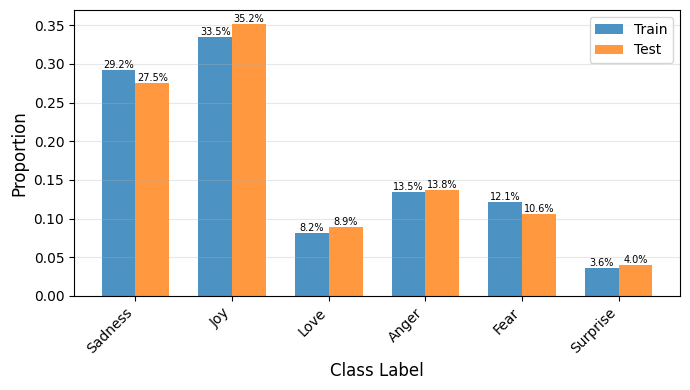

In [140]:
plot_class_distribution(dataset, fname="plots/class_dist")

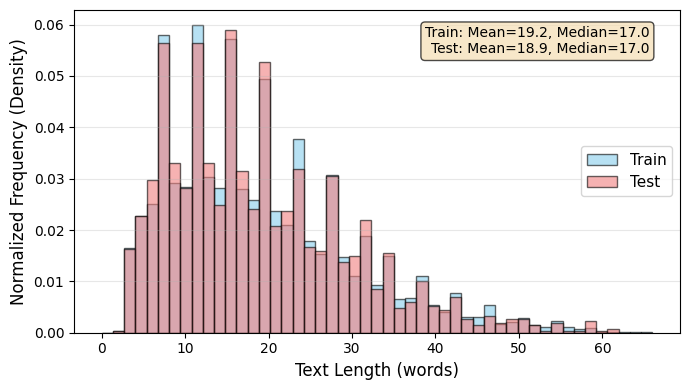

In [141]:
plot_length_distribution(dataset, fname="plots/len_dist")

In [144]:
_, tokenizer = load_hf_classifier("google/electra-small-discriminator", 6, False)
dataset_w_val = preprocess(dataset, tokenizer)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15938 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

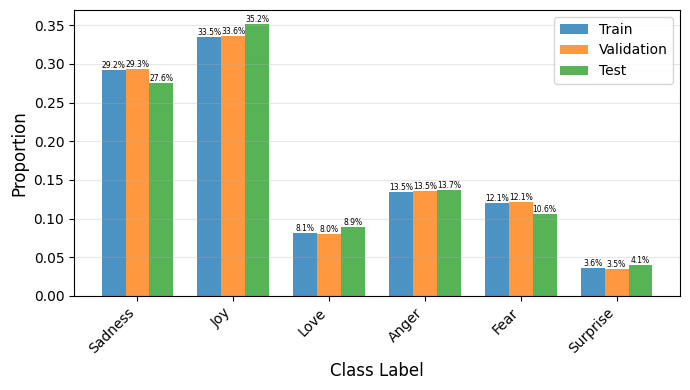

In [163]:
plot_class_distribution(dataset_w_val, fname="plots/class_dist_w_val")

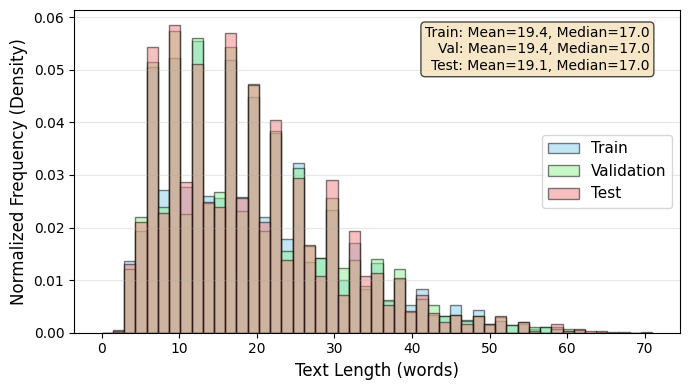

In [161]:
plot_length_distribution(dataset_w_val, fname="plots/len_dist_w_val")